In [84]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_csv('assr_data.csv').set_index('Subject')

In [3]:
td_info = pd.read_csv('td_info.csv', index_col=0).dropna(subset='gender')
asd_info = pd.read_csv('asd_info.csv', index_col=0).dropna(subset='Пол')

In [4]:
td_info['gender'] = td_info['gender'].apply(lambda x: int(x.lower() == 'm'))
asd_info['gender'] = asd_info['Пол'].apply(lambda x: int(x.lower() == 'm'))

In [5]:
age = pd.concat([td_info[['gender']], asd_info[['gender']]])

In [6]:
df = df.join(age, how='left')

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df['age'] = df['age'].str.replace(',', '.')
df['assr'] = df['assr'].str.replace(',', '.')

In [10]:
df['age'] = df['age'].astype(float)
df['assr'] = df['assr'].astype(float)

In [11]:
td = df[df['group'] == 'TD']
asd = df[df['group'] == 'ASD']

## Статистический анализ

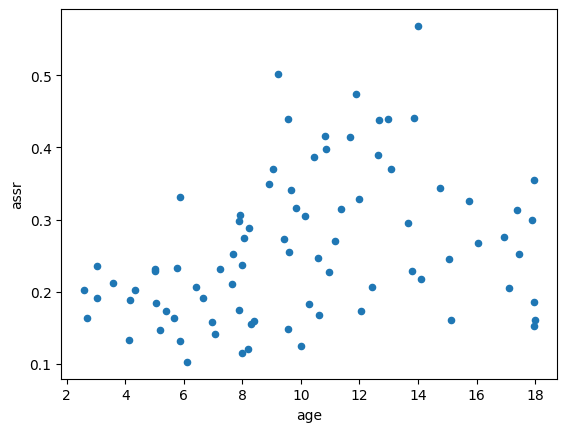

In [7]:
# норма
td.plot(kind='scatter', x='age', y='assr');

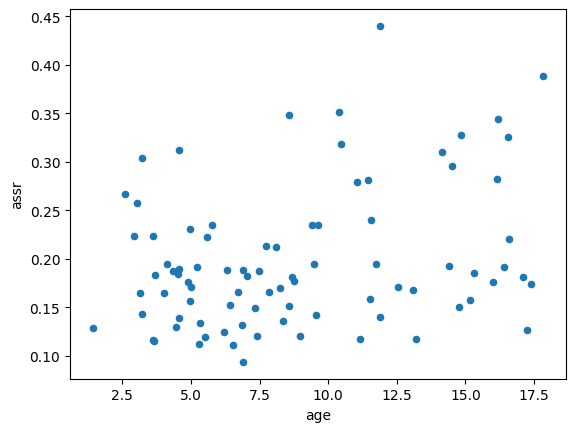

In [8]:
# рас
asd.plot(kind='scatter', x='age', y='assr');

In [9]:
asd['assr'].mean()

np.float64(0.1982342588235294)

In [10]:
td['assr'].mean()

np.float64(0.25958255421686754)

Средний ITPC у нормотипичных детей и детей с РАС, вроде, сильно отличаются, но у нас выборки с различным распределением возраста, что может вносить вклад:

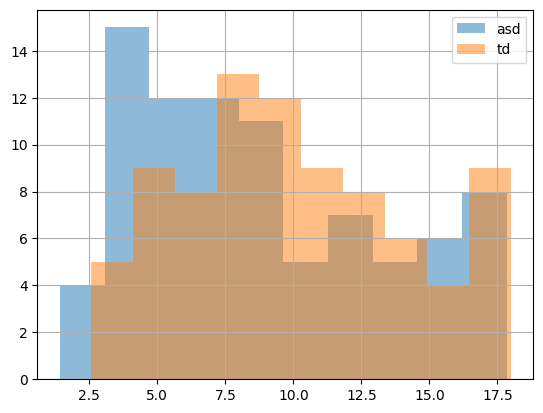

In [11]:
asd['age'].hist(alpha=0.5, label='asd')
td['age'].hist(alpha=0.5, label='td')
plt.legend();

In [12]:
df['bin'] = pd.qcut(df['age'], 6)

In [13]:
df.groupby(['bin', 'group'])[['assr', 'age']].agg(['mean', 'count'])

/var/folders/nf/ddjglggx5ld4cfvyhldzm1g40000gn/T/ipykernel_86593/1178030911.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['bin', 'group'])[['assr', 'age']].agg(['mean', 'count'])


assr              age      
                           mean count       mean count
bin             group                                 
(1.419, 4.96]   ASD    0.190102    20   3.711000    20
                TD     0.191127     8   3.445000     8
(4.96, 6.907]   ASD    0.158504    16   5.851250    16
                TD     0.193772    12   5.660833    12
(6.907, 8.715]  ASD    0.185172    13   7.870769    13
                TD     0.208231    15   7.833333    15
(8.715, 11.15]  ASD    0.216875    10   9.890000    10
                TD     0.301097    19  10.032105    19
(11.15, 14.543] ASD    0.225567    12  12.660833    12
                TD     0.353544    15  12.813333    15
(14.543, 17.99] ASD    0.230644    14  16.254286    14
                TD     0.253114    14  16.815714    14

#### Корреляция

__Пирсона__

In [30]:
stats.pearsonr(td['age'], td['assr'])

PearsonRResult(statistic=np.float64(0.3311760754309248), pvalue=np.float64(0.0022267440028145478))

In [31]:
stats.pearsonr(asd['age'], asd['assr'])

PearsonRResult(statistic=np.float64(0.29492522444134567), pvalue=np.float64(0.006143044470404898))

И у нормотипичных детей, и у детей с РАС стат. значимая корреляция Пирсона между возрастом и ITPC

__Спирмена__

In [98]:
stats.spearmanr(td['age'], td['assr'])

SignificanceResult(statistic=np.float64(0.3855397662527298), pvalue=np.float64(0.00031898446108032244))

In [99]:
stats.spearmanr(asd['age'], asd['assr'])

SignificanceResult(statistic=np.float64(0.21989661811307862), pvalue=np.float64(0.043160590055766154))

Стат. значимая корреляция Спирмена и у TD, и у ASD группы. Однако более выражена у нормотипичных детей (и выражена сильнее, чем корреляция Пирсона)

__Линейная регрессия__ (пока без разбиения на трейн и тест, смотрим на значимость линейной зависимости возраста от ITPC)

In [16]:
td_linreg = stats.linregress(td['assr'], td['age'])
td_linreg

LinregressResult(slope=np.float64(13.765723338614315), intercept=np.float64(6.441357170300474), rvalue=np.float64(0.3311760754309248), pvalue=np.float64(0.002226744002814555), stderr=np.float64(4.357839428993699), intercept_stderr=np.float64(1.2135675209677639))

In [17]:
asd_linreg = stats.linregress(asd['assr'], asd['age'])
asd_linreg

LinregressResult(slope=np.float64(18.37813921839576), intercept=np.float64(5.163293781720973), rvalue=np.float64(0.2949252244413457), pvalue=np.float64(0.006143044470404849), stderr=np.float64(6.535675883845881), intercept_stderr=np.float64(1.3777015498948655))

Есть стат. значимая линейная зависимость у обеих групп детей.

Насколько значимы различия в моделях по slope и intercept:

In [18]:
t = (td_linreg.slope - asd_linreg.slope) / np.sqrt(td_linreg.stderr ** 2 + asd_linreg.stderr ** 2)
print('p-val:', stats.t.pdf(t, td.shape[0] + asd.shape[0] - 4))

p-val: 0.33496892612270374


In [19]:
# не уверен, что тут df правильно считаю, но -4 не влияет на результат, так как много наблюдений
t = (td_linreg.intercept - asd_linreg.intercept) / np.sqrt(td_linreg.intercept_stderr ** 2 + asd_linreg.intercept_stderr ** 2)
print('p-val:', stats.t.pdf(t, td.shape[0] + asd.shape[0] - 4))

p-val: 0.3122741333070696


#### Значимость пола

In [85]:
mod = sm.OLS(td['age'], sm.add_constant(td[['assr', 'gender']]))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.928
Date:                Sun, 19 Jan 2025   Prob (F-statistic):            0.00959
Time:                        19:57:53   Log-Likelihood:                -231.89
No. Observations:                  83   AIC:                             469.8
Df Residuals:                      80   BIC:                             477.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4403      1.273      5.061      0.0

Кажется, пол здесь не значим

### SRS

In [88]:
td_srs = pd.read_csv('td_srs_data.csv', index_col=0).T.iloc[:, -6:]
td_srs = td_srs.join(df, how='inner')

In [89]:
asd_srs = pd.read_csv('srs_data.csv', index_col=0).T.iloc[:, -6:]
asd_srs = asd_srs.join(df, how='inner')

<Axes: xlabel='Com', ylabel='assr'>

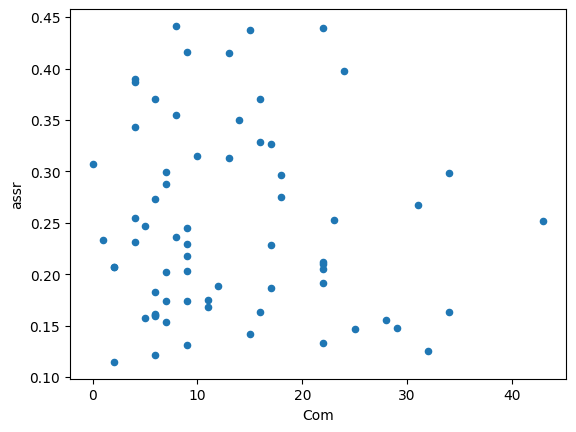

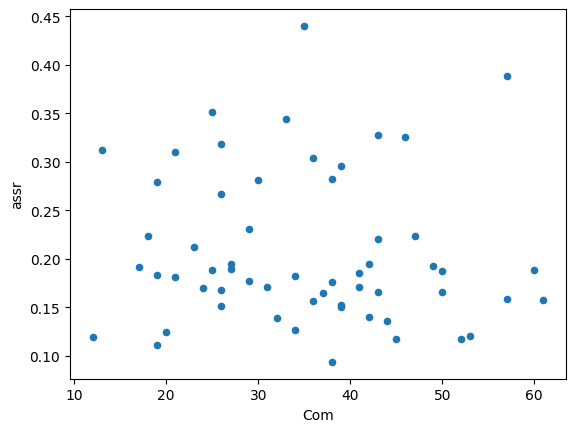

In [90]:
td_srs.plot(kind='scatter', x='Com', y='assr')
asd_srs.plot(kind='scatter', x='Com', y='assr')

In [91]:
stats.pearsonr(td_srs['assr'], td_srs['Com'])

PearsonRResult(statistic=np.float64(-0.06485731515681505), pvalue=np.float64(0.6020610370570848))

In [102]:
stats.pearsonr(asd_srs['assr'], asd_srs['Com'])

PearsonRResult(statistic=np.float64(-0.08254475994565218), pvalue=np.float64(0.5378878703145433))

In [106]:
stats.pearsonr(td_srs['assr'], td_srs['Total'])

PearsonRResult(statistic=np.float64(-0.02691430609302638), pvalue=np.float64(0.8288347045899194))

In [109]:
stats.pearsonr(asd_srs['assr'], asd_srs['Total'])

PearsonRResult(statistic=np.float64(-0.05453194186491482), pvalue=np.float64(0.6843274863193496))

<Axes: xlabel='assr', ylabel='Awr'>

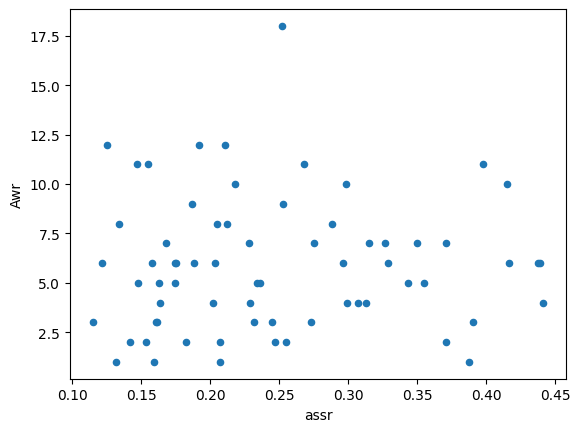

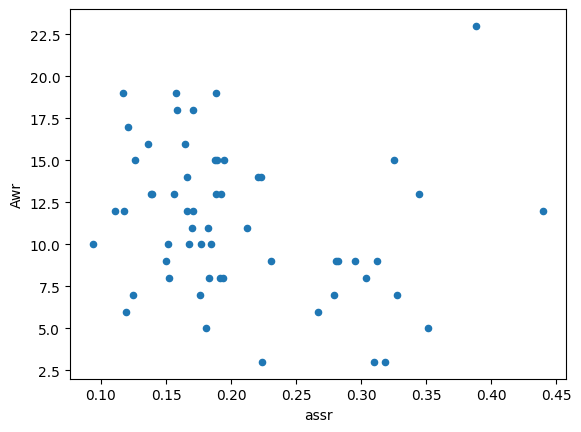

In [30]:
td_srs.plot(kind='scatter', x='assr', y='Awr')
asd_srs.plot(kind='scatter', x='assr', y='Awr')

In [120]:
stats.spearmanr(td_srs['assr'], td_srs['Awr'])

SignificanceResult(statistic=np.float64(0.07200209556792025), pvalue=np.float64(0.5625731779371294))

In [121]:
stats.spearmanr(asd_srs['assr'], asd_srs['Awr'])

SignificanceResult(statistic=np.float64(-0.2820579054456538), pvalue=np.float64(0.03194560096947192))

## Линейная регрессия

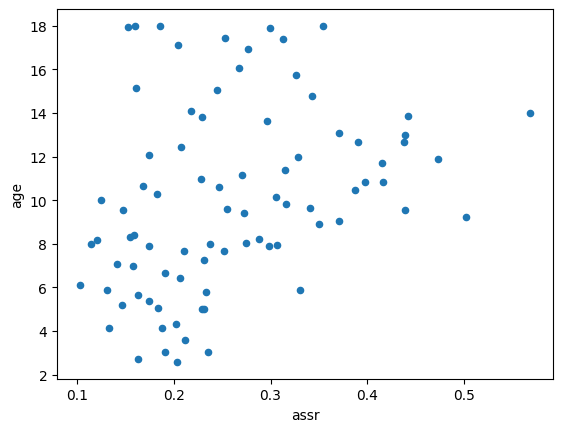

In [280]:
td.plot(kind='scatter', x='assr', y='age');

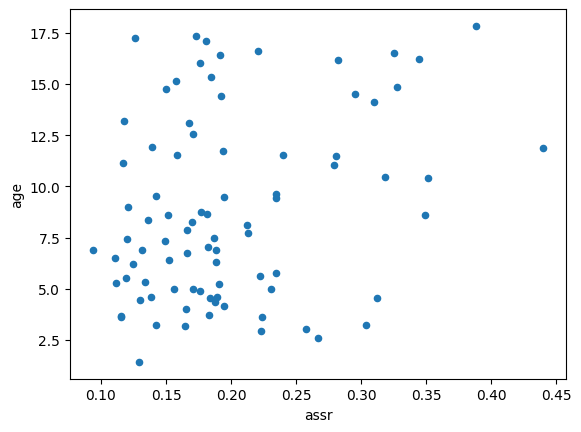

In [281]:
asd.plot(kind='scatter', x='assr', y='age');

Кажется, что здесь нелинейная зависимость. В эксельке наивысший R^2 у степенной зависимости (без разбиения на тест и трейн):
https://docs.google.com/spreadsheets/d/1XzapDAItTLVvwwmQ3lVM1jv1u0hK0HeRYkD4U3ha1Bw/edit?usp=sharing

In [383]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import root_mean_squared_error as rmse, mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


RANDOM_SEED = 42
cv_generator = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

In [321]:
def print_metrics(cv_res):
    print('test mean MAE:', -cv_res['test_neg_mean_absolute_error'].mean().round(3), '±', cv_res['test_neg_mean_absolute_error'].std().round(3))
    print('test mean MSE:', -cv_res['test_neg_mean_squared_error'].mean().round(3), '±', cv_res['test_neg_mean_squared_error'].std().round(3))
    print('test mean RMSE:', -cv_res['test_neg_root_mean_squared_error'].mean().round(3), '±', cv_res['test_neg_root_mean_squared_error'].std().round(3))
    print('test mean R^2:', cv_res['test_r2'].mean().round(3), '±', cv_res['test_r2'].std().round(3))

In [322]:
X = td[['assr']]
y = td['age']

In [323]:
metrics = ['neg_mean_absolute_error', 
           'neg_mean_squared_error',
           'neg_root_mean_squared_error',
           'r2'
          ]

In [324]:
model = LinearRegression()
cv_res = cross_validate(model, X, y, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.193 ± 0.093
test mean MSE: 16.131 ± 1.024
test mean RMSE: 4.014 ± 0.126
test mean R^2: 0.055 ± 0.045


In [325]:
poly = PolynomialFeatures()
X_poly = poly.fit_transform(X)[:, 1:]

In [326]:
model = LinearRegression()
cv_res = cross_validate(model, X_poly, y, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.24 ± 0.145
test mean MSE: 16.264 ± 0.932
test mean RMSE: 4.031 ± 0.116
test mean R^2: 0.046 ± 0.061


Посмотрим метрики модели на детях с РАС:

In [376]:
model = LinearRegression()
cv_res = cross_validate(model, X, y, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)

In [377]:
cv_res

{'fit_time': array([0.00289321, 0.00164199, 0.00134087]),
 'score_time': array([0.00332975, 0.00237894, 0.00179291]),
 'estimator': [LinearRegression(), LinearRegression(), LinearRegression()],
 'test_neg_mean_absolute_error': array([-3.09289954, -3.31690818, -3.16833178]),
 'train_neg_mean_absolute_error': array([-3.17205782, -3.15448109, -3.05015228]),
 'test_neg_mean_squared_error': array([-15.20831982, -15.62475597, -17.55910904]),
 'train_neg_mean_squared_error': array([-15.86756   , -15.83743231, -14.93944397]),
 'test_neg_root_mean_squared_error': array([-3.89978459, -3.95281621, -4.19035906]),
 'train_neg_root_mean_squared_error': array([-3.9834106 , -3.97962716, -3.86515769]),
 'test_r2': array([0.11625115, 0.03663152, 0.01151465]),
 'train_r2': array([0.09965476, 0.11971396, 0.10659809])}

In [378]:
best_model = cv_res['estimator'][0]

In [379]:
X_asd = asd[['assr']]
y_asd = asd['age']

In [394]:
print('MAE:', np.round(mae(y_asd, best_model.predict(X_asd)), 3))
print('MSE:', np.round(mse(y_asd, best_model.predict(X_asd)), 3))
print('RMSE:', np.round(rmse(y_asd, best_model.predict(X_asd)),3))
print('R^2:', np.round(r2_score(y_asd, best_model.predict(X_asd)), 3))

MAE: 3.62
MSE: 18.549
RMSE: 4.307
R^2: 0.07


In [375]:
model = LinearRegression()
cv_res = cross_validate(model, X_asd, y_asd, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.693 ± 0.133
test mean MSE: 20.219 ± 2.817
test mean RMSE: 4.486 ± 0.309
test mean R^2: -0.08 ± 0.087


В целом, модель, построенная на данных ASD, сильнее ошибается